In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import json as js
import ast
import re
import networkx as nx
from datetime import datetime

In [5]:
# open file as a dataframe
with open(r"corona_tweets_09_includes.tweets.txt", encoding="utf8") as corona_file:
    tw=[]
    line= corona_file.readlines()
    for row in range(len(line)):
        temp = ast.literal_eval(line[row])
        tw.append(temp)

    tws_df=pd.DataFrame(tw)
    print(tws_df.head())

                                 attachments            author_id  \
0                                        NaN           2719753171   
1                                        NaN  1241296875459768320   
2                                        NaN             22677397   
3  {'media_keys': ['3_1243070023922401286']}             72283791   
4  {'media_keys': ['7_1242768383495585792']}  1123676073701646337   

                                 context_annotations  \
0  [{'domain': {'id': '10', 'name': 'Person', 'de...   
1  [{'domain': {'id': '123', 'name': 'Ongoing New...   
2  [{'domain': {'id': '10', 'name': 'Person', 'de...   
3  [{'domain': {'id': '10', 'name': 'Person', 'de...   
4  [{'domain': {'id': '10', 'name': 'Person', 'de...   

                 created_at  \
0  2020-03-26T03:54:14.000Z   
1  2020-03-26T06:15:50.000Z   
2  2020-03-26T01:43:33.000Z   
3  2020-03-26T06:59:25.000Z   
4  2020-03-25T11:00:55.000Z   

                                            entities  geo  \


In [8]:
print(tws_df.columns)

Index(['attachments', 'author_id', 'context_annotations', 'created_at',
       'entities', 'geo', 'id', 'in_reply_to_user_id', 'lang',
       'possibly_sensitive', 'public_metrics', 'referenced_tweets', 'source',
       'text', 'withheld', 'time'],
      dtype='object')


In [16]:
tws_df.shape #534546 rows in total

(534546, 18)

In [3]:
#helper function to convert to hour
def process_time(df):
    time_str = df['created_at'][11:19]
    time_whole = datetime.strptime(time_str, '%H:%M:%S')
    return int(datetime.strftime(time_whole, '%H'))

#Add a hour time column
tws_df['time'] = np.NaN
tws_df['time'] = tws_df.apply(process_time, axis=1)

<b>Histogram showing time of day when people post tweets<b>

note: the time zone is UTC 0 (noted by 'z' from the 'created_at' attribute)

more to concern: the location should also be considered

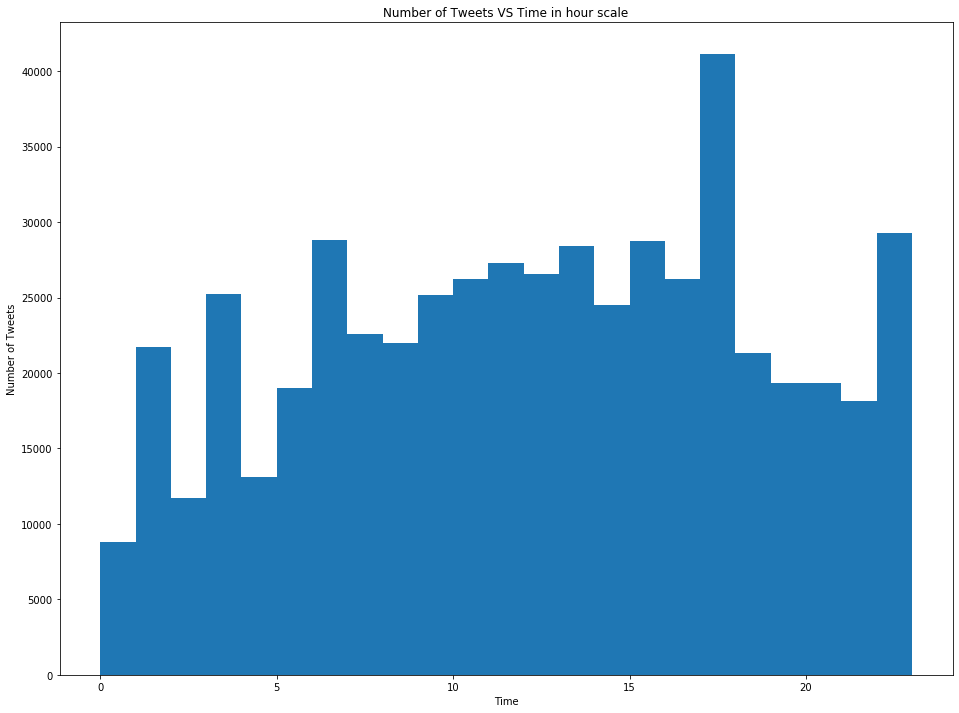

In [4]:
#plot the histogram graph
plt.figure(figsize=(16,12)) 
plt.hist(tws_df['time'],bins=range(0, 24, 1) )
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets VS Time in hour scale')
plt.show()

<b>Scatter plot<b>

like VS retweet

In [6]:
def count_retweets(df):
    rtw_dic =  df['public_metrics']
    return rtw_dic.get('retweet_count')
    
#make an empty column and apply the function 
tws_df['retweets_counts'] = np.NaN
tws_df['retweets_counts'] = tws_df.apply(count_retweets, axis=1)

In [7]:
def count_likes(df):
    rtw_dic =  df["public_metrics"]
    return rtw_dic.get("like_count")
    
#make an empty column and apply the function 
tws_df['likes_counts'] = np.NaN
tws_df['likes_counts'] = tws_df.apply(count_likes, axis=1)

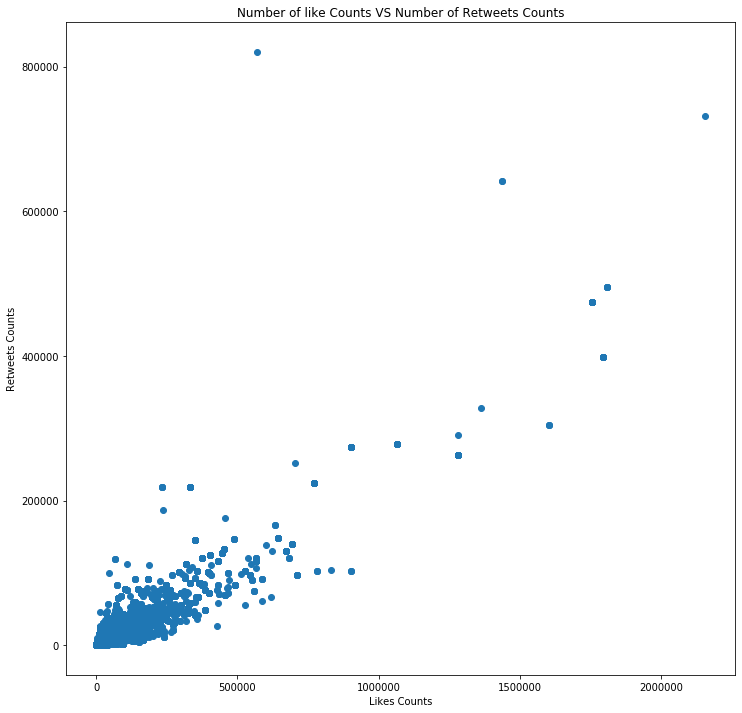

In [8]:
#draw the scatter plot
plt.figure(figsize=(12,12)) 
plt.scatter(tws_df['likes_counts'],tws_df['retweets_counts'])
plt.xlabel('Likes Counts')
plt.ylabel('Retweets Counts')
plt.title('Number of Like Counts VS Number of Retweets Counts')
plt.show()

mention VS like

In [9]:
def count_mentions(df):
    #check if there is no entities as a float, and if yes, check if there is mentions
    if isinstance(df.loc['entities'],float):
        return 0
    elif 'mentions' in df['entities']:
        return len(df['entities'].get('mentions'))
    else:
        return 0
    
#make an empty column and apply the function 
tws_df['mention_counts'] = np.NaN
tws_df['mention_counts'] = tws_df.apply(count_mentions, axis=1)

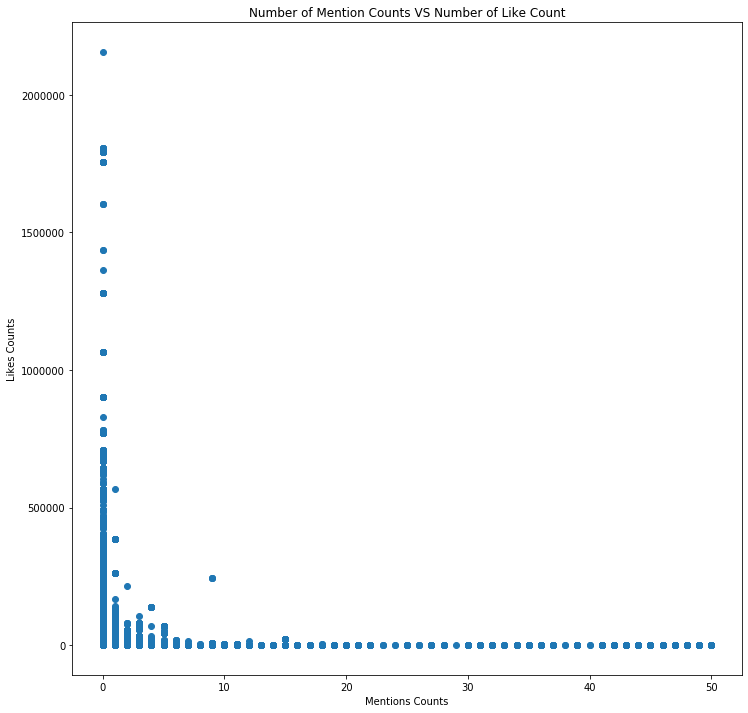

In [51]:
#draw the scatter plot
plt.figure(figsize=(12,12)) 
plt.scatter(tws_df['mention_counts'],tws_df['likes_counts'])
plt.xlabel('Mentions Counts')
plt.ylabel('Likes Counts')
plt.title('Number of Mention Counts VS Number of Like Count')
plt.show()

Insights: some tweets have a huge amount of mentions, but alsmost no like; try to take a deeper look to see if they are actually spam

In [41]:
#print(tws_df['mention_counts'].tolist())

index = tws_df.index
apples_indices = index[tws_df["mention_counts"] == 50]

apples_indices_list = apples_indices.tolist()

print(apples_indices_list)

[3710, 111120, 171329, 283903, 285487, 390575, 500641, 503651, 510814, 528475, 531128]


In [52]:
print(tws_df.loc[[3710]])

                                     attachments   author_id  \
3710  {'media_keys': ['16_1243065964234711041']}  2484109496   

                                    context_annotations  \
3710  [{'domain': {'id': '46', 'name': 'Brand Catego...   

                    created_at  \
3710  2020-03-26T06:43:18.000Z   

                                               entities  geo  \
3710  {'urls': [{'start': 943, 'end': 966, 'url': 'h...  NaN   

                       id in_reply_to_user_id lang  possibly_sensitive  \
3710  1243065976549228545           230652338   en               False   

                                         public_metrics  \
3710  {'retweet_count': 1, 'reply_count': 2, 'like_c...   

                                      referenced_tweets               source  \
3710  [{'type': 'replied_to', 'id': '124300687543768...  Twitter for Android   

                                                   text withheld  \
3710  @annasantoz318 @MrShikharMisra @PySohapy @Traz...  

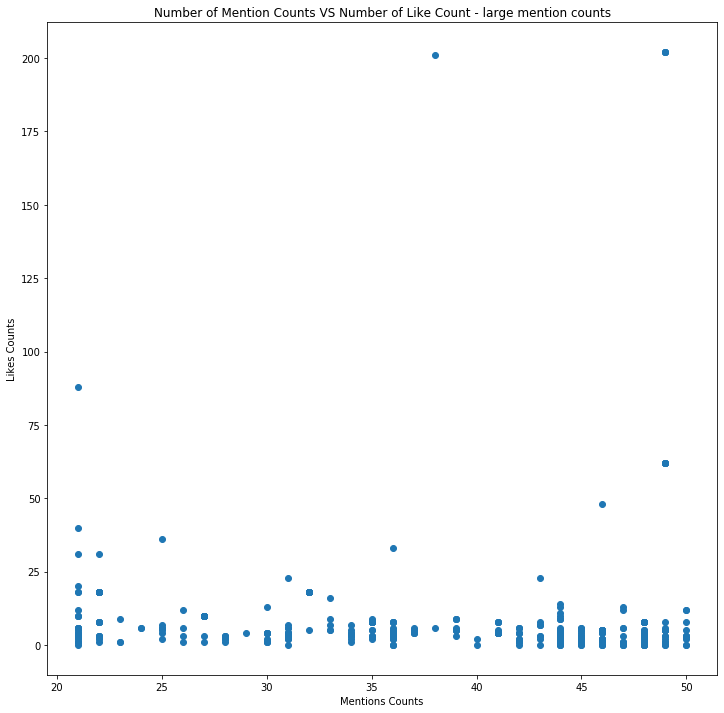

In [55]:
mention_sub_df = tws_df[tws_df['mention_counts'] >20]
#draw the scatter plot
plt.figure(figsize=(12,12)) 
plt.scatter(mention_sub_df['mention_counts'],mention_sub_df['likes_counts'])
plt.xlabel('Mentions Counts')
plt.ylabel('Likes Counts')
plt.title('Number of Mention Counts VS Number of Like Count - large mention counts')
plt.show()

mention vs reply

In [48]:
def count_reply(df):
    rtw_dic =  df['public_metrics']
    return rtw_dic.get('reply_count')
    
#make an empty column and apply the function 
tws_df['reply_counts'] = np.NaN
tws_df['reply_counts'] = tws_df.apply(count_reply, axis=1)

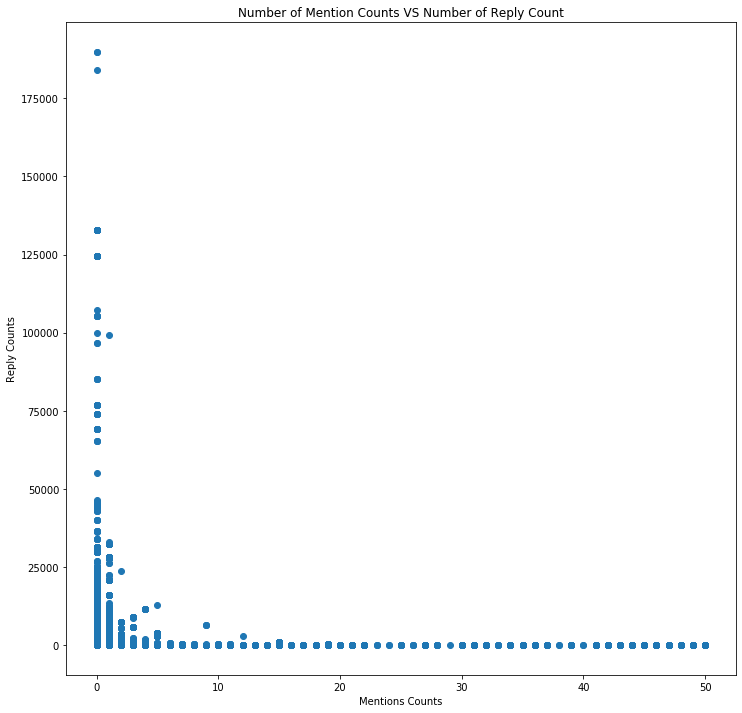

In [49]:
#draw the scatter plot
plt.figure(figsize=(12,12)) 
plt.scatter(tws_df['mention_counts'],tws_df['reply_counts'])
plt.xlabel('Mentions Counts')
plt.ylabel('Reply Counts')
plt.title('Number of Mention Counts VS Number of Reply Count')
plt.show()

Insights: show similar trend as like counts

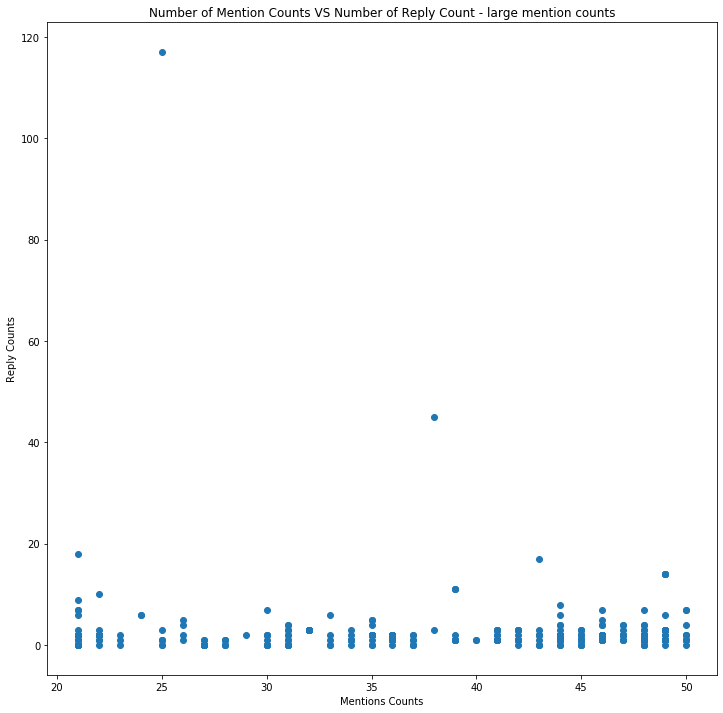

In [56]:
mention_sub_df = tws_df[tws_df['mention_counts'] >20]
#draw the scatter plot
plt.figure(figsize=(12,12)) 
plt.scatter(mention_sub_df['mention_counts'],mention_sub_df['reply_counts'])
plt.xlabel('Mentions Counts')
plt.ylabel('Reply Counts')
plt.title('Number of Mention Counts VS Number of Reply Count - large mention counts')
plt.show()

<b>Networks<b>

In [10]:
print(tws_df['referenced_tweets'])

0                                                       NaN
1         [{'type': 'quoted', 'id': '1242809270678126597'}]
2                                                       NaN
3                                                       NaN
4                                                       NaN
5                                                       NaN
6                                                       NaN
7                                                       NaN
8         [{'type': 'quoted', 'id': '1243060293405560832'}]
9                                                       NaN
10                                                      NaN
11                                                      NaN
12                                                      NaN
13                                                      NaN
14                                                      NaN
15                                                      NaN
16                                      

In [58]:
reference_dic = {}

#helper function to append to the reference_dic, use set to avoid double-counting
def add_to_dict(my_dict, id, df):
    set_per_id = set()
    sub_df = df[df['id'] == id]
    sub_df = sub_df.dropna(subset=['referenced_tweets']) #remove NaN
    all_ref = sub_df['referenced_tweets'].tolist()
    for i in all_ref:
        for j in i:
            set_per_id.add(j.get('id'))
    my_dict[id]=set_per_id

In [59]:
#get all unique author id for a subset of the dataset (by sampling)
tws_df_sub = tws_df.sample(frac= 0.01)
id_list = tws_df_sub['id'].unique()

for my_id in id_list:
    add_to_dict(reference_dic,my_id,tws_df)

In [60]:
reference_dic

{'1242876719650004992': set(),
 '1243096128133857280': set(),
 '1243343778158727168': {'1243343475799719938'},
 '1243207018091106306': set(),
 '1243127991787536384': set(),
 '1243289661507874823': {'1243280735798202372'},
 '1243196339539734529': set(),
 '1243079674118508545': set(),
 '1243013014762094592': set(),
 '1243093860252860417': set(),
 '1243023427750875138': set(),
 '1243061963384471552': {'1243036024961470465'},
 '1243164187318050817': {'1243152110696329216'},
 '1242224208400117760': set(),
 '1243150420047851520': set(),
 '1243224876942491648': set(),
 '1243239910326272000': {'1243236979032154112'},
 '1243180452480831488': {'1243101455243866112'},
 '1243109800872820736': {'1243109247790927875'},
 '1243116412639399937': set(),
 '1243177592359878658': {'1243119862207184896'},
 '1243178139616006145': set(),
 '1243268031196753920': set(),
 '1243229549782941696': set(),
 '1243051185235349504': set(),
 '1243234523275390976': set(),
 '1243208941330292737': set(),
 '12431523097371770

In [61]:
g = nx.DiGraph()
g.add_nodes_from(reference_dic.keys())

for k, v in reference_dic.items():
    g.add_edges_from(([(k, t) for t in v]))

<function matplotlib.pyplot.show(*args, **kw)>

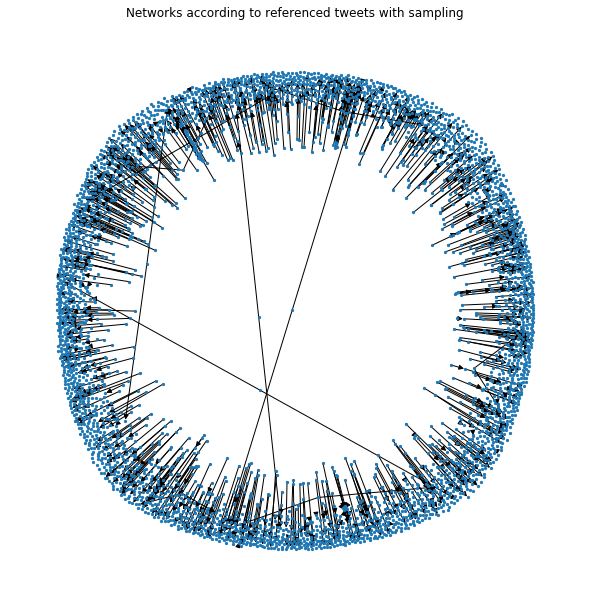

In [63]:
plt.figure(figsize=(8,8)) 
nx.draw(g,node_size=5)
plt.title('Networks according to referenced tweets with sampling')
plt.show